In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from matplotlib import rc
from matplotlib.font_manager import FontProperties
import seaborn as sns

rc('text', usetex=True)
rc('font', family='serif')
rc('text.latex', preamble=r'\usepackage{cmbright} \fontsize{28pt}{28pt}\selectfont')

# Define font properties for Computer Modern, 11pt
font_properties = FontProperties(family='serif', style='normal', weight='normal', size=28)

# Set plot style
# plt.style.use('seaborn-v0_8')

In [72]:
def load_data(base_path):
    data = {}
    controllers = ['pid', 'rvolmea']
    
    for controller in controllers:
        path = os.path.join(base_path, controller)
        files = glob.glob(os.path.join(path, '*.csv'))
        data[controller] = []
        for f in sorted(files):
            df = pd.read_csv(f)
            df = df[700:]  # Discard first 500 rows
            df.reset_index(drop=True, inplace=True)
            data[controller].append(df)
            print(f"Loaded {f} with shape {df.shape}")
            
    return data

base_path = '.'
data = load_data(base_path)

Loaded ./pid/traj_pid_1.csv with shape (9301, 12)
Loaded ./pid/traj_pid_2.csv with shape (9301, 12)
Loaded ./pid/traj_pid_3.csv with shape (9301, 12)
Loaded ./pid/traj_pid_4.csv with shape (9301, 12)
Loaded ./pid/traj_pid_5.csv with shape (9301, 12)
Loaded ./rvolmea/traj_rvolmea_1.csv with shape (9301, 12)
Loaded ./rvolmea/traj_rvolmea_2.csv with shape (9301, 12)
Loaded ./rvolmea/traj_rvolmea_3.csv with shape (9301, 12)


In [73]:
def calculate_errors(data):
    for controller, trials in data.items():
        for i, df in enumerate(trials):
            # Position error (XY only per request)
            df['pos_error_x'] = df['gx'] - df['x']
            df['pos_error_y'] = df['gy'] - df['y']
            if controller == "pid":
                df['z'] -= 0.3
            df['pos_error_z'] = df['gz'] - df['z']
            df['pos_error_norm'] = np.sqrt(df['pos_error_x']**2 + df['pos_error_y']**2 + df['pos_error_z']**2)
            
            # Yaw error (handling wrap around if necessary, but simple diff for now)
            df['yaw_error'] = df['target_yaw'] - df['yaw']

calculate_errors(data)

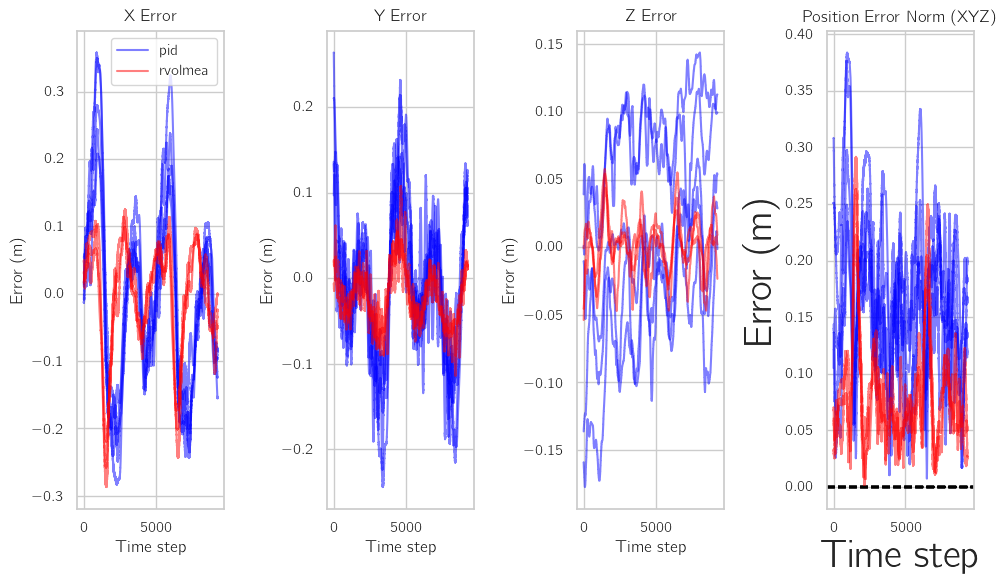

In [74]:
def plot_errors(data):
    fig, axes = plt.subplots(1, 4, figsize=(10, 6))
    sns.set(style="whitegrid")
    
    metrics = ['pos_error_x', 'pos_error_y', 'pos_error_z', 'pos_error_norm']
    titles = ['X Error', 'Y Error', 'Z Error', 'Position Error Norm (XYZ)']
    
    colors = {'pid': 'blue', 'rvolmea': 'red'}
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        for controller, trials in data.items():
            for j, df in enumerate(trials):
                label = f"{controller}" if i == 0 else None # Only label once
                ax.plot(df.index, df[metric], color=colors[controller], alpha=0.5, label=label if j==0 else "")
                plt.xlabel("Timestep", fontproperties=font_properties)
                plt.ylabel("$Error (m)$", fontproperties=font_properties)
                plt.axhline(0, color="black", linestyle="--")
        
        ax.set_title(titles[i])
        ax.set_xlabel('Time step')
        ax.set_ylabel('Error (m)')
        if i == 0:
            ax.legend()
        ax.grid(True)





        
    plt.tight_layout()
    plt.show()

plot_errors(data)

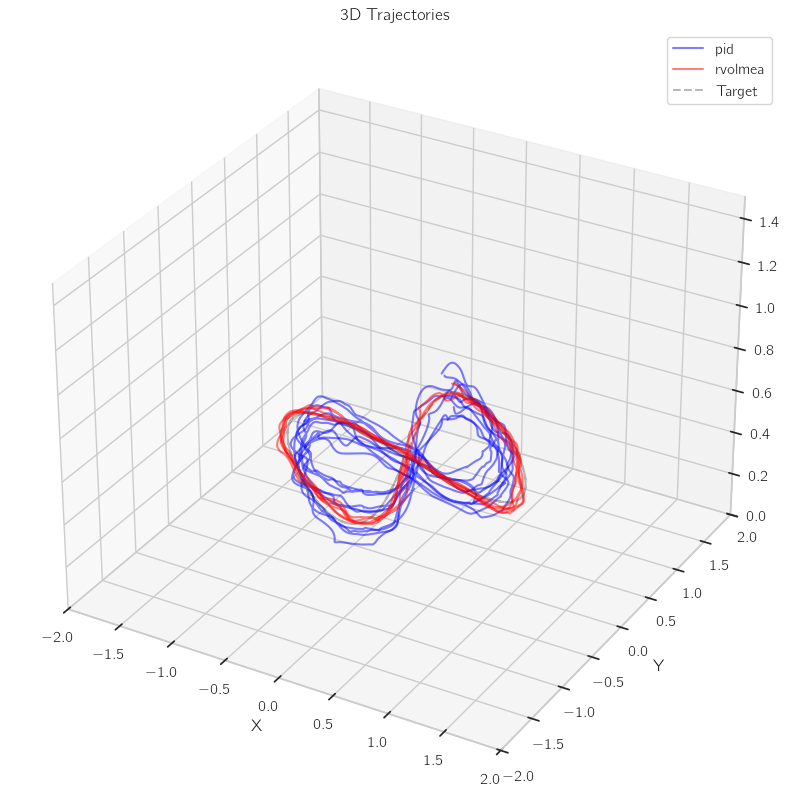

In [75]:
def plot_3d_trajectories(data):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = {'pid': 'blue', 'rvolmea': 'red'}
    
    for controller, trials in data.items():
        # if controller == 'pid':
        #     continue  # Skip rvolmea for 3D plot as per request
        for j, df in enumerate(trials):
            label = f"{controller}"
            ax.plot(df['x'], df['y'], df['z'], color=colors[controller], alpha=0.5, label=label if j==0 else "")
            
            # Plot target if available (assuming constant or changing target)
            # Just plotting the first trial's target to avoid clutter if they are similar
            if controller == 'rvolmea' and j == 0:
                 ax.plot(df['gx'], df['gy'], df['gz'], 'k--', alpha=0.3, label='Target')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    #set x y z limits
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([0, 1.5])

    ax.set_title('3D Trajectories')
    ax.legend()
    plt.show()

plot_3d_trajectories(data)

In [76]:
def print_summary_stats(data):
    summary = []
    
    for controller, trials in data.items():
        all_pos_errors = []
        all_yaw_errors = []
        
        for df in trials:
            # RMSE for this trial
            rmse = np.sqrt((df['pos_error_norm']**2).mean())
            all_pos_errors.append(rmse)
            
        summary.append({
            'Controller': controller,
            'Mean RMSE Position (m)': np.mean(all_pos_errors),
            'Std RMSE Position (m)': np.std(all_pos_errors),
            'Num Trials': len(trials)
        })
        
    summary_df = pd.DataFrame(summary)
    print(summary_df)
    return summary_df

summary_df = print_summary_stats(data)

  Controller  Mean RMSE Position (m)  Std RMSE Position (m)  Num Trials
0        pid                0.172168               0.025117           5
1    rvolmea                0.093192               0.007340           3


Detailed Descriptive Statistics:
  Controller             Metric      Mean  Variance   Std Dev  Best (Min)  Worst (Max)     Range
0        pid  Position RMSE (m)  0.172168  0.000631  0.025117    0.133962     0.202663  0.068701
1    rvolmea  Position RMSE (m)  0.093192  0.000054  0.007340    0.085198     0.102923  0.017725

Statistical Significance Test (T-Test) between pid and rvolmea:
Position RMSE: t-statistic=5.8119, p-value=0.0019
  -> Significant difference in Position RMSE (p < 0.05)


/tmp/ipykernel_83628/2579475102.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(pos_data, labels=controllers)


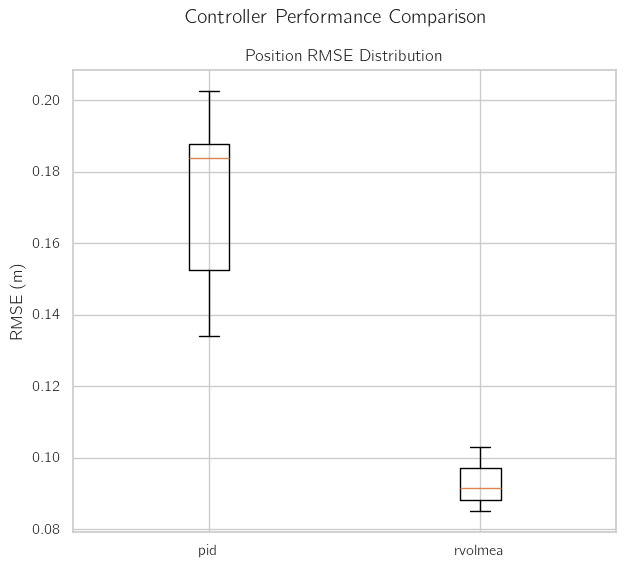

In [77]:
from scipy import stats

def detailed_statistical_analysis(data):
    stats_results = []
    
    # Prepare lists for t-test
    pos_rmse_distributions = {}

    for controller, trials in data.items():
        # Collect all RMSEs for position across trials
        trial_rmses = []
        
        for i, df in enumerate(trials):
            rmse = np.sqrt((df['pos_error_norm']**2).mean())
            trial_rmses.append(rmse)
            
        # Convert to numpy arrays
        trial_rmses = np.array(trial_rmses)
        
        pos_rmse_distributions[controller] = trial_rmses
        
        # Basic Statistics
        stats_results.append({
            'Controller': controller,
            'Metric': 'Position RMSE (m)',
            'Mean': np.mean(trial_rmses),
            'Variance': np.var(trial_rmses),
            'Std Dev': np.std(trial_rmses),
            'Best (Min)': np.min(trial_rmses),
            'Worst (Max)': np.max(trial_rmses),
            'Range': np.max(trial_rmses) - np.min(trial_rmses)
        })

    stats_df = pd.DataFrame(stats_results)
    
    print("Detailed Descriptive Statistics:")
    print(stats_df.to_string())
    
    # T-Test (assuming independent samples)
    controllers = list(data.keys())
    if len(controllers) == 2:
        c1, c2 = controllers
        print(f"\nStatistical Significance Test (T-Test) between {c1} and {c2}:")
        
        # Position RMSE T-Test
        t_stat_pos, p_val_pos = stats.ttest_ind(pos_rmse_distributions[c1], pos_rmse_distributions[c2], equal_var=False)
        print(f"Position RMSE: t-statistic={t_stat_pos:.4f}, p-value={p_val_pos:.4f}")
        if p_val_pos < 0.05:
            print(f"  -> Significant difference in Position RMSE (p < 0.05)")
        else:
            print(f"  -> No significant difference in Position RMSE (p >= 0.05)")

    # Box plot for visual comparison
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    
    # Prepare data for plotting
    pos_data = [pos_rmse_distributions[c] for c in controllers]
    
    ax.boxplot(pos_data, labels=controllers)
    ax.set_title('Position RMSE Distribution')
    ax.set_ylabel('RMSE (m)')
    ax.grid(True)
    
    plt.suptitle('Controller Performance Comparison')
    plt.show()

detailed_statistical_analysis(data)